# Calculating MFCCs from Speech Signal in Python

In this example we'll go over how to use Python to calculate the MFCCs from a speech signal. Common libraries like librosa for audio processing and numpy, scipy, and matplotlib will be used. Lastly, we'll utilize ipywidgets to build a basic GUI that will allow users to test the model in real time.

Original Signal $\rightarrow$ Pre-emphasis $\rightarrow$ Framing $\rightarrow$ Windowing $\rightarrow$ FFT $\rightarrow$ Mel-filterbank $\rightarrow$ Logarithm $\rightarrow$ MFCCs

In [90]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.fftpack import dct

In [2]:
audio_path = librosa.example('trumpet')

In [3]:
ipd.Audio(audio_path)

In [4]:
y, sr = librosa.load(audio_path)

In [5]:
y.shape

(117601,)

In [6]:
sr

22050

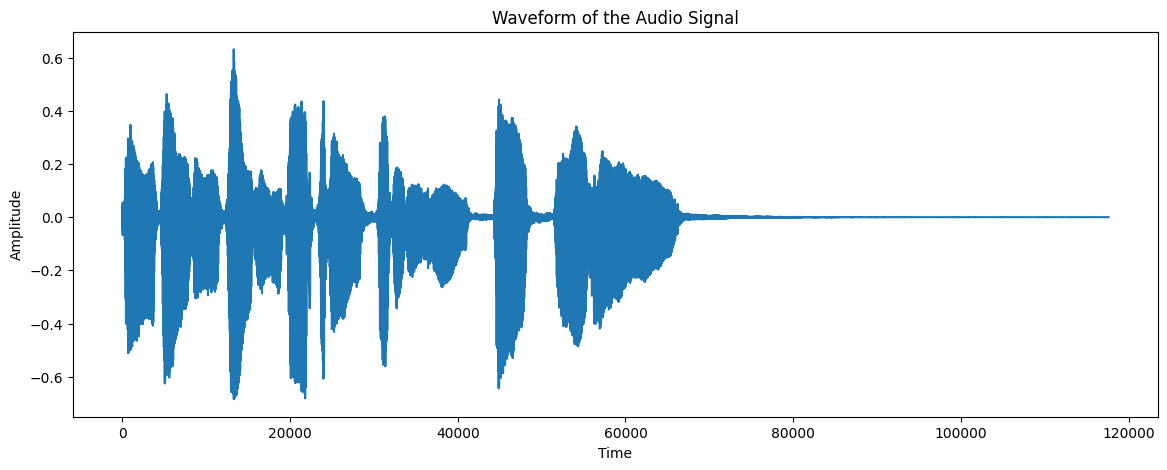

In [7]:
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

### Apply pre-emphasis

Mathematics of Pre-emphasis:

$$
y[n] = x[n] - \alpha.x[n-1]
$$

- $x[n]$: signal
- $\alpha$: pre-emphasis level - 0.97 $\rightarrow$ optimize performance for speech natural

In [8]:
def apply_pre_emphasis(
        x,
        alpha
):
    y = np.empty_like(x)

    y[0] = x[0]
    y[1:] = x[1:] - alpha * x[:-1]

    return y

In [9]:
pre_emphasis = 0.97 # optimize for speech natural

In [10]:
y_preemphasized = apply_pre_emphasis(
    x=y,
    alpha=pre_emphasis
)

In [11]:
y_preemphasized

array([-1.4068211e-03,  9.1854157e-04,  2.1711632e-05, ...,
        2.1854270e-05, -3.8140439e-05,  4.2269563e-05],
      shape=(117601,), dtype=float32)

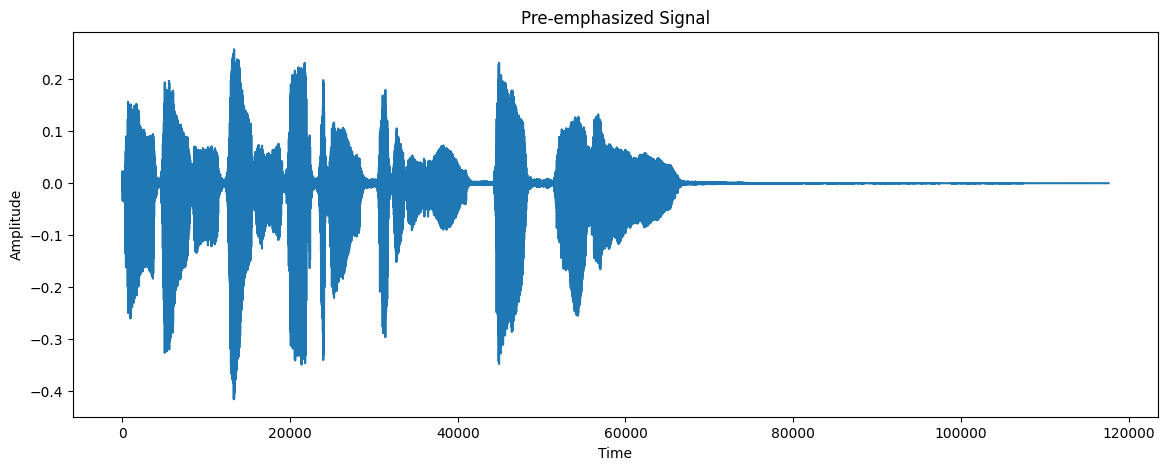

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(y_preemphasized)
plt.title('Pre-emphasized Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

### Framing

#### Mathematics of Framing

Frame of k:
$$
x_{k}[n] = x[n + kH]
$$
$$
 n=0,1,...,L-1
$$

Amount of frames:
$$
N_{frames} = 1 + [\frac{N - L}{H}]
$$

In [13]:
frame_size = 0.025 # 25ms

In [14]:
frame_stride = 0.01 # 10ms

In [15]:
frame_length = sr * frame_size

frame_length

551.25

In [16]:
frame_step = sr * frame_stride

frame_step

220.5

In [17]:
signal_length = len(y_preemphasized)

signal_length

117601

In [18]:
frame_length = int(round(frame_length))

frame_length

551

In [19]:
frame_step = int(round(frame_step))

frame_step

220

In [20]:
num_frames = int(
    np.ceil(
        float(np.abs(signal_length - frame_length)) / frame_step
    )
)

num_frames

533

Pad signal to ensure all frames have equal number of samples

pad_signal_length:
$$
N_{frames}.H + L
$$

In [21]:
pad_signal_length = num_frames * frame_step + frame_length

pad_signal_length

117811

In [22]:
pad_zeros = pad_signal_length - signal_length

pad_zeros

210

In [23]:
pad_signal = np.append(
    y_preemphasized,
    np.zeros(pad_zeros)
)

pad_signal

array([-1.40682107e-03,  9.18541569e-04,  2.17116321e-05, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00], shape=(117811,))

Slice the signal into frames

Sum of 2 matrixs:

In [24]:
indices = np.tile(
    np.arange(0, frame_length),
    (num_frames, 1)
) + np.tile(
    np.arange(0, num_frames * frame_step, frame_step),
    (frame_length, 1)
).T


indices

array([[     0,      1,      2, ...,    548,    549,    550],
       [   220,    221,    222, ...,    768,    769,    770],
       [   440,    441,    442, ...,    988,    989,    990],
       ...,
       [116600, 116601, 116602, ..., 117148, 117149, 117150],
       [116820, 116821, 116822, ..., 117368, 117369, 117370],
       [117040, 117041, 117042, ..., 117588, 117589, 117590]],
      shape=(533, 551))

In [25]:
frames = pad_signal[
    indices.astype(np.int32, copy=False)
]

frames

array([[-1.40682107e-03,  9.18541569e-04,  2.17116321e-05, ...,
         3.55587453e-02,  1.56822950e-02, -4.10702229e-02],
       [-5.63117489e-03, -1.41065568e-03,  2.57698819e-04, ...,
         1.42513365e-01,  1.47614956e-01,  1.03099361e-01],
       [ 3.93831730e-02,  3.08982581e-02, -2.55626589e-02, ...,
         3.83607298e-02,  2.09875554e-02,  7.02038407e-04],
       ...,
       [ 1.18127600e-05, -1.08885652e-05,  2.57683296e-05, ...,
         2.27308337e-05, -3.88585904e-05,  3.59577352e-05],
       [-1.22506126e-05, -8.42996542e-07,  2.04897879e-05, ...,
         2.53477883e-05, -1.73019343e-05, -1.59951469e-06],
       [-1.46692685e-06,  7.85028078e-06, -1.20321301e-05, ...,
        -1.74547349e-05,  2.73947753e-05, -2.25815984e-05]],
      shape=(533, 551))

In [26]:
frames.shape

(533, 551)

- 0: amount of frames
- 1: samples on each frame

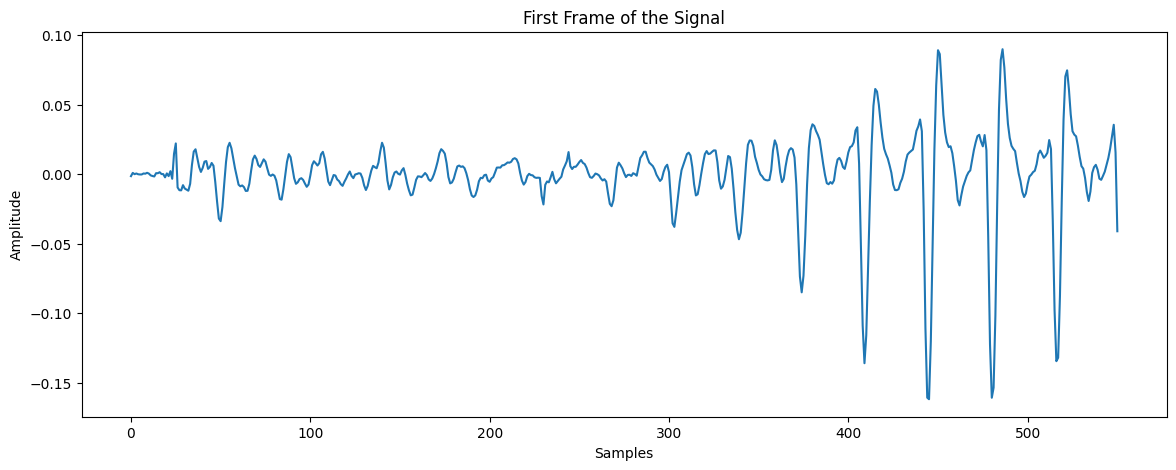

In [27]:
plt.figure(figsize=(14, 5))
plt.plot(frames[0])
plt.title('First Frame of the Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

### Windowing

$$
w[n] = \alpha - (1 - \alpha).cos(\frac{2\pi n}{N - 1})
$$
$$
0 \leq n \leq N - 1
$$

- $N$: frame length
- $\alpha$: cosine coefficient

![](image1.png)

Apply by Numpy

In [28]:
frames *= np.hamming(frame_length)

frames

array([[-1.12545686e-04,  7.35108968e-05,  1.73953730e-06, ...,
         2.84896885e-03,  1.25505432e-03, -3.28561783e-03],
       [-4.50493991e-04, -1.12894797e-04,  2.06468452e-05, ...,
         1.14181795e-02,  1.18136273e-02,  8.24794888e-03],
       [ 3.15065384e-03,  2.47278810e-03, -2.04808180e-03, ...,
         3.07346403e-03,  1.67963440e-03,  5.61630726e-05],
       ...,
       [ 9.45020802e-07, -8.71412047e-07,  2.06456015e-06, ...,
         1.82119579e-06, -3.10985363e-06,  2.87661882e-06],
       [-9.80049008e-07, -6.74650270e-08,  1.64164306e-06, ...,
         2.03086636e-06, -1.38467409e-06, -1.27961175e-07],
       [-1.17354148e-07,  6.28258099e-07, -9.64015006e-07, ...,
        -1.39847443e-06,  2.19240432e-06, -1.80652787e-06]],
      shape=(533, 551))

Apply a window function to each frame to minimize discontinuities at the edges

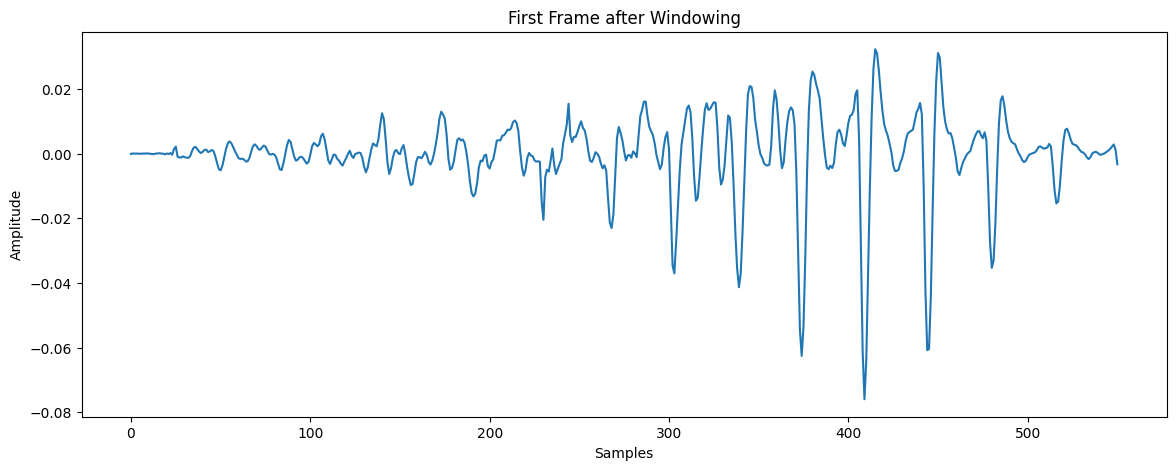

In [29]:
plt.figure(figsize=(14, 5))
plt.plot(frames[0])
plt.title('First Frame after Windowing')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

### Fast Fourier Transform (FFT)

Convert each frame from the time domain to the frequency domain.






This code using RFFT(Real FFT) to get magnitude:

$$
X_{r}[k] = \sum^{N-1}_{n=0}{x[n].e^{-j2\pi n.\frac{k}{N}}}
$$
$$
k = 0,1,...,\frac{N}{2}
$$

- x[n] is real number, not imaginary number

Code by Mathematics

In [30]:
def rfft(
        x
):

    N = len(x)

    k_max = N // 2

    X = np.zeros(
        k_max + 1,
        dtype=complex
    )

    for k in range(k_max + 1):

        s = 0.0 + 0.0j

        for n in range(N):
            angle = -2j * np.pi * n * k / N
            s += x[n] * np.exp(angle)

        X[k] = s

    return X

In [31]:
NFFT = 512

In [32]:
mag_frames = np.absolute(
    np.fft.rfft(frames, NFFT)
)

mag_frames

array([[1.68175819e-02, 1.69484636e-02, 1.65530120e-02, ...,
        1.12155240e-03, 1.14209515e-03, 1.12603484e-03],
       [5.47145082e-02, 5.48877820e-02, 5.53756938e-02, ...,
        8.96390190e-03, 8.95261423e-03, 8.96509183e-03],
       [1.17807727e-02, 1.19416436e-02, 1.22889118e-02, ...,
        1.33232713e-03, 1.33504070e-03, 1.33034422e-03],
       ...,
       [3.05655434e-06, 3.05918680e-06, 3.06684423e-06, ...,
        1.58470867e-04, 9.33325190e-04, 7.91449058e-04],
       [7.37176532e-10, 6.56892897e-09, 1.29176622e-08, ...,
        7.85448483e-04, 1.15365979e-03, 5.18592295e-04],
       [1.10593635e-06, 1.10484547e-06, 1.10508461e-06, ...,
        7.75561998e-04, 9.40078199e-04, 1.56674206e-03]], shape=(533, 257))

Power Spectrum:

In [33]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

pow_frames

array([[5.52404413e-07, 5.61035973e-07, 5.35160557e-07, ...,
        2.45679644e-09, 2.54761980e-09, 2.47647356e-09],
       [5.84702620e-06, 5.88411839e-06, 5.98919426e-06, ...,
        1.56936596e-07, 1.56541605e-07, 1.56978265e-07],
       [2.71067588e-07, 2.78521197e-07, 2.94955767e-07, ...,
        3.46698355e-09, 3.48112043e-09, 3.45667138e-09],
       ...,
       [1.82471181e-14, 1.82785622e-14, 1.83701827e-14, ...,
        4.90488589e-11, 1.70135920e-09, 1.22342112e-09],
       [1.06138523e-21, 8.42789605e-20, 3.25910149e-19, ...,
        1.20494008e-09, 2.59947443e-09, 5.25269469e-10],
       [2.38885785e-15, 2.38414750e-15, 2.38517970e-15, ...,
        1.17479768e-09, 1.72606840e-09, 4.79429821e-09]], shape=(533, 257))

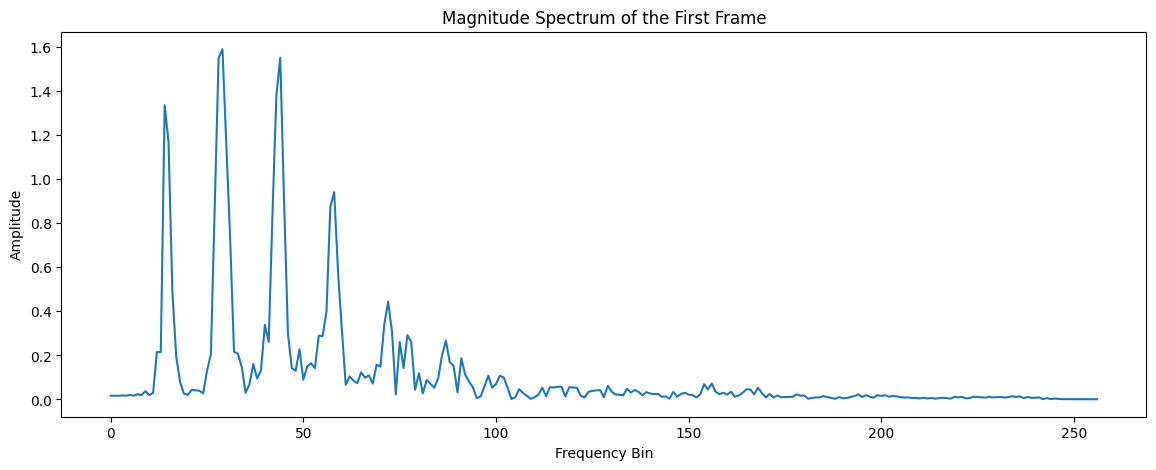

In [34]:
# Plot the magnitude spectrum of the first frame
plt.figure(figsize=(14, 5))
plt.plot(mag_frames[0])
plt.title('Magnitude Spectrum of the First Frame')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
plt.show()

# Apply Mel-filterbank

Apply a filterbank to the power spectra to get the energy in each Mel-frequency bin.

In [35]:
number_filters = 40

In [36]:
low_freq_mel = 0

low_freq_mel

0

$$
m = 2595.log_{10}(1 + \frac{sr}{2}.\frac{1}{700})
$$

In [40]:
def calculate_mels(
        sr,
):
    return  2595 * np.log10(1 + (sr / 2) / 700)

In [41]:
high_freq_mel = calculate_mels(sr)

high_freq_mel

np.float64(3176.318435512582)

Range points with same spaced in Mel Scale

In [42]:
mel_points = np.linspace(
    low_freq_mel,
    high_freq_mel,
    number_filters + 2 # Plus 2 points
)

mel_points

array([   0.        ,   77.47118135,  154.94236271,  232.41354406,
        309.88472542,  387.35590677,  464.82708812,  542.29826948,
        619.76945083,  697.24063219,  774.71181354,  852.18299489,
        929.65417625, 1007.1253576 , 1084.59653896, 1162.06772031,
       1239.53890166, 1317.01008302, 1394.48126437, 1471.95244573,
       1549.42362708, 1626.89480843, 1704.36598979, 1781.83717114,
       1859.3083525 , 1936.77953385, 2014.2507152 , 2091.72189656,
       2169.19307791, 2246.66425926, 2324.13544062, 2401.60662197,
       2479.07780333, 2556.54898468, 2634.02016603, 2711.49134739,
       2788.96252874, 2866.4337101 , 2943.90489145, 3021.3760728 ,
       3098.84725416, 3176.31843551])

Convert mel to frequency

$$
f = 700.(10^{\frac{m}{2595}} - 1)
$$

In [43]:
def convert_mel_to_hz(
        m
):
    return 700 * (10 ** (m / 2959) - 1)

In [45]:
hz_points = convert_mel_to_hz(mel_points)

hz_points

array([   0.        ,   43.49761809,   89.69815445,  138.76956692,
        190.89025019,  246.24968429,  305.04912342,  367.50232761,
        433.83633984,  504.2923114 ,  579.12637859,  658.6105939 ,
        743.03391497,  832.70325516,  927.94459922, 1029.10418844,
       1136.54977935, 1250.67198065, 1371.88567329, 1500.63151865,
       1637.37756059, 1782.62092699, 1936.88963692, 2100.74452033,
       2274.78125679, 2459.63254111, 2655.97038338, 2864.50855206,
       3086.00516876, 3321.26546438, 3571.14470642, 3836.55130822,
       4118.45013147, 4417.86599379, 4735.88739444, 5073.67047143,
       5432.44320452, 5813.50987952, 6218.25582979, 6648.1524726 ,
       7104.76265825, 7589.74635171])

bin:
$$
k = \frac{f.NFFT}{sr}
$$

In [46]:
def calculate_bin(
        NFFT,
        hz_points,
        sample_rate
):
    return np.floor(
        (hz_points * (NFFT)) // sr
    )

In [47]:
bin = calculate_bin(
    NFFT + 1,
    hz_points,
    sr
)

bin

array([  0.,   1.,   2.,   3.,   4.,   5.,   7.,   8.,  10.,  11.,  13.,
        15.,  17.,  19.,  21.,  23.,  26.,  29.,  31.,  34.,  38.,  41.,
        45.,  48.,  52.,  57.,  61.,  66.,  71.,  77.,  83.,  89.,  95.,
       102., 110., 118., 126., 135., 144., 154., 165., 176.])

In [48]:
fbank = np.zeros(
    (number_filters, int(np.floor(NFFT / 2 + 1)))
)

fbank

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(40, 257))

A Filter Mel has:
- Increase Linear 0 $\rightarrow$ 1 (left $\rightarrow$ peak)
- Decrease Linear 1 $\rightarrow$ 0 (peak $\rightarrow$ right)


1. Increase (left $\rightarrow$ center):
$$
H_{m}(k) = \frac{k - f_{m - 1}}{f_{m} - f_{m - 1}}
$$
$$
for f_{m-1} \leq k \leq f_{m}
$$

2. Decrease (center $\rightarrow$ right):
$$
H_{m}(k) = \frac{f_{m+1} - k}{f_{m+1} - f_{m}}
$$
$$
for f_{m} \leq k \leq f_{m+1}
$$

In [85]:
for m in range(1, number_filters + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

np.dot: multiple 2 matrixs

$$
MelEnergy(n, m) = \sum^{K - 1}_{k=0}PowerSpectrum(n, k).H_{m}(k)
$$

In [86]:
filter_banks = np.dot(pow_frames, fbank.T)

filter_banks

array([[5.61035973e-07, 5.35160557e-07, 6.53756841e-07, ...,
        9.66111021e-06, 3.05697994e-05, 2.30667711e-05],
       [5.88411839e-06, 5.98919426e-06, 6.05704176e-06, ...,
        5.03320688e-05, 6.39250478e-05, 4.07457981e-05],
       [2.78521197e-07, 2.94955767e-07, 3.26337566e-07, ...,
        3.37340551e-04, 1.84958034e-04, 1.15348987e-04],
       ...,
       [1.82785622e-14, 1.83701827e-14, 1.85267085e-14, ...,
        4.24625786e-09, 6.37134894e-09, 8.44233610e-09],
       [8.42789605e-20, 3.25910149e-19, 7.01089800e-19, ...,
        3.29888043e-09, 3.55159586e-09, 3.65774824e-09],
       [2.38414750e-15, 2.38517970e-15, 2.38922897e-15, ...,
        3.25443755e-09, 4.59275245e-09, 4.27562701e-09]], shape=(533, 40))

numerical stability (avoid log(0) when convert to dB):

$$
MelEnergy(n,m) =
\begin{cases}
ϵ & if \space MelEnergy(n,m)=0 \\
MelEnergy(n,m) & inverse
\end{cases}
$$

$$
ϵ≈2.220446049250313×10−16
$$

In [87]:
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)

filter_banks

array([[5.61035973e-07, 5.35160557e-07, 6.53756841e-07, ...,
        9.66111021e-06, 3.05697994e-05, 2.30667711e-05],
       [5.88411839e-06, 5.98919426e-06, 6.05704176e-06, ...,
        5.03320688e-05, 6.39250478e-05, 4.07457981e-05],
       [2.78521197e-07, 2.94955767e-07, 3.26337566e-07, ...,
        3.37340551e-04, 1.84958034e-04, 1.15348987e-04],
       ...,
       [1.82785622e-14, 1.83701827e-14, 1.85267085e-14, ...,
        4.24625786e-09, 6.37134894e-09, 8.44233610e-09],
       [8.42789605e-20, 3.25910149e-19, 7.01089800e-19, ...,
        3.29888043e-09, 3.55159586e-09, 3.65774824e-09],
       [2.38414750e-15, 2.38517970e-15, 2.38922897e-15, ...,
        3.25443755e-09, 4.59275245e-09, 4.27562701e-09]], shape=(533, 40))

get power to easy for see mel spectrogram:

$$
m_{dB} = 20.log_{10}(m)
$$

In [88]:
filter_banks = 20 * np.log10(filter_banks)

filter_banks

array([[-125.02018583, -125.43031806, -123.69167508, ..., -100.29945927,
         -90.29414822,  -92.74026388],
       [-104.60637195, -104.45263201, -104.35478864, ...,  -85.96310437,
         -83.88657877,  -87.79834342],
       [-131.10283495, -130.60486216, -129.72665861, ...,  -69.438629  ,
         -74.65853598,  -78.7597243 ],
       ...,
       [-274.76115937, -274.71773051, -274.64403463, ..., -167.43987273,
        -163.91537218, -161.47074724],
       [-381.48561659, -369.73804231, -363.08452703, ..., -169.63266851,
        -168.99152918, -168.7357238 ],
       [-292.45333761, -292.44957791, -292.43484458, ..., -169.75048116,
        -166.75853926, -167.38000377]], shape=(533, 40))

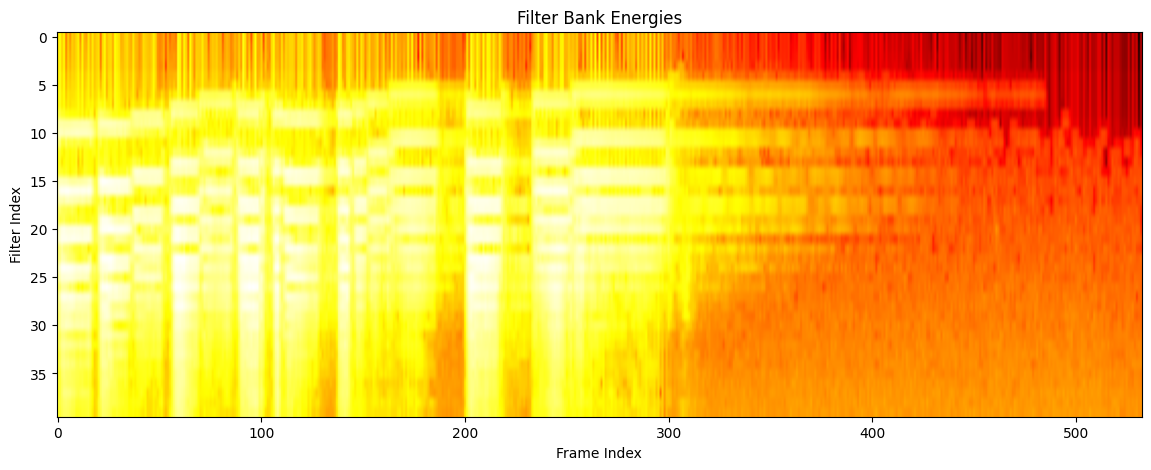

In [89]:
plt.figure(figsize=(14, 5))
plt.imshow(filter_banks.T, cmap='hot', aspect='auto')
plt.title('Filter Bank Energies')
plt.xlabel('Frame Index')
plt.ylabel('Filter Index')
plt.show()

# DCT

In [91]:
num_ceps = 12

- cepstral coefficient (MFCC coefficients)

DCT by Scipy:

In [92]:
mfcc = dct(
    filter_banks,
    type=2,
    axis=1,
    norm='ortho',
)[:, :num_ceps]

In [96]:
mfcc

array([[ -526.76512591,   -51.12935879,  -117.19120397, ...,
           26.50397153,    14.66737056,   -16.08500019],
       [ -445.02386304,   -47.24993925,  -110.31369261, ...,
           25.96573751,    17.27076808,   -15.4833208 ],
       [ -445.57442691,  -131.84896798,  -133.36046231, ...,
           38.30296219,    23.36773293,   -11.67005656],
       ...,
       [-1339.81808893,  -218.97586891,   -57.15122125, ...,
          -22.92864506,   -16.45597014,   -11.02743636],
       [-1469.90009017,  -384.38901431,  -181.7888544 , ...,
          -26.76003202,   -29.68848639,   -22.46801312],
       [-1392.60058273,  -264.21461612,   -70.21385939, ...,
          -16.38160255,    10.83667567,    -1.76884531]], shape=(533, 12))

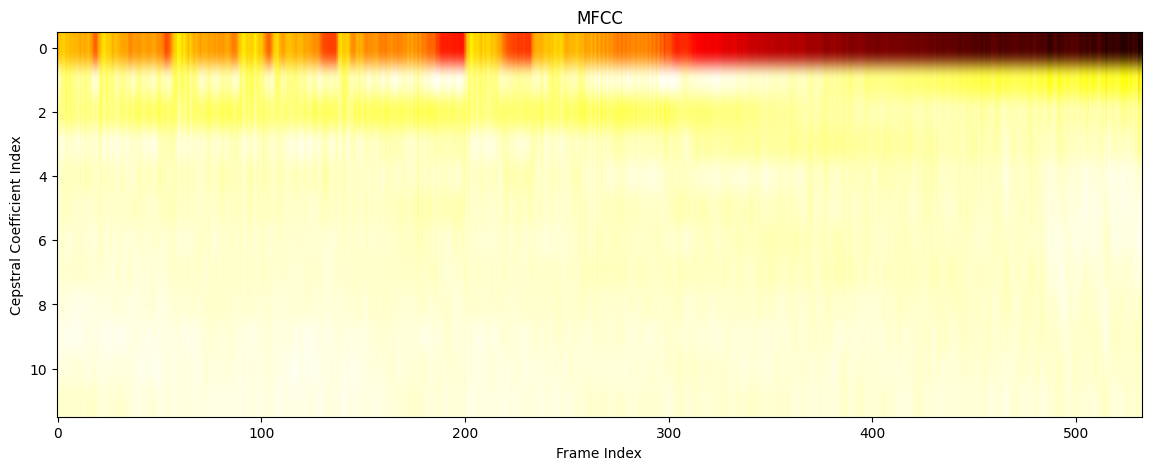

In [93]:
plt.figure(figsize=(14, 5))
plt.imshow(mfcc.T, cmap='hot', aspect='auto')
plt.title('MFCC')
plt.xlabel('Frame Index')
plt.ylabel('Cepstral Coefficient Index')
plt.show()

Discrete Cosine Transform(DCT) type-II standard:

$$
X[k] = \sum^{N-1}_{n=0}{x[n].cos[\frac{\pi}{N}k(n + \frac{1}{2})]}
$$
$$
k=0,1,...,N-1
$$

Discrete Cosine Transform(DCT) (ortho) same with Spicy:

$$
X[k] = \sqrt{\frac{2}{N}}\sum^{N-1}_{n=0}{x[n].cos[\frac{\pi}{N}k(n + \frac{1}{2})]}
$$
$$
k=0,1,...,N-1
$$

In [94]:
def dct_ortho(
        x
):

    x = np.atleast_2d(x)

    N = x.shape[1]

    # Create cosine matrix
    n = np.arange(N)
    k = np.arange(N).reshape(-1, 1) # k x 1
    cos_matrix = np.cos(np.pi / N * k * (n + 1/2))

    # standardize ortho
    X = np.dot(x, cos_matrix.T) * np.sqrt(2 / N)

    # MFCC Standardize
    X[:, 0] = X[:, 0] / np.sqrt(2)

    return X

In [107]:
mfcc_math = dct_ortho(filter_banks)[:, :num_ceps]

In [108]:
mfcc_math

array([[ -526.76512591,   -51.12935879,  -117.19120397, ...,
           26.50397153,    14.66737056,   -16.08500019],
       [ -445.02386304,   -47.24993925,  -110.31369261, ...,
           25.96573751,    17.27076808,   -15.4833208 ],
       [ -445.57442691,  -131.84896798,  -133.36046231, ...,
           38.30296219,    23.36773293,   -11.67005656],
       ...,
       [-1339.81808893,  -218.97586891,   -57.15122125, ...,
          -22.92864506,   -16.45597014,   -11.02743636],
       [-1469.90009017,  -384.38901431,  -181.7888544 , ...,
          -26.76003202,   -29.68848639,   -22.46801312],
       [-1392.60058273,  -264.21461612,   -70.21385939, ...,
          -16.38160255,    10.83667567,    -1.76884531]], shape=(533, 12))

.T: Transpose -> flip axis

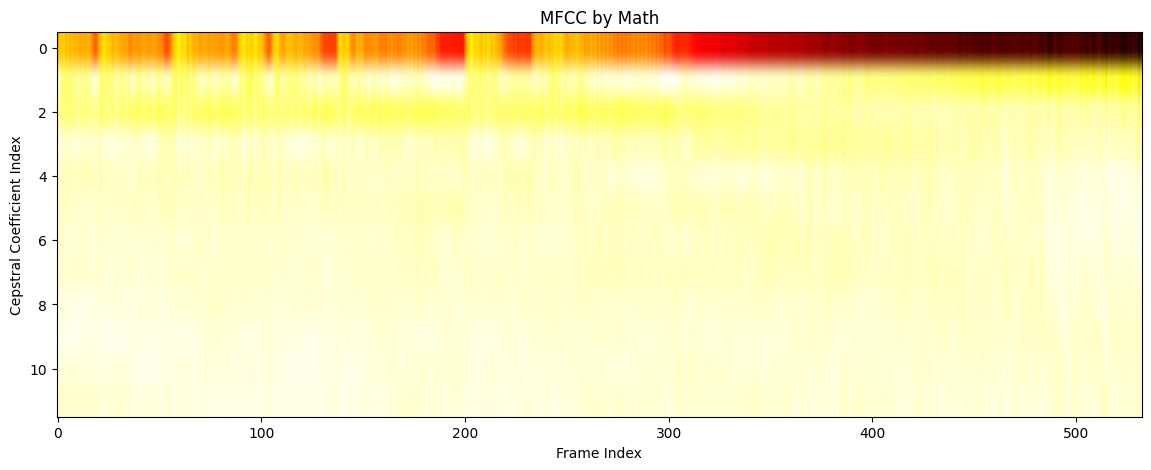

In [111]:
plt.figure(figsize=(14, 5))
plt.imshow(mfcc_math.T, cmap='hot', aspect='auto')
plt.title('MFCC by Math')
plt.xlabel('Frame Index')
plt.ylabel('Cepstral Coefficient Index')
plt.show()